In [1]:
#contains functions which creates the dataset used for the problem
#the dataset is created by turning already clicked pictures into numerical arrays and taking their corresponding labels

#import important libraries
import numpy as np
import cv2
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf

#creating dataset
def createDatasetHelmet():
    dataHelmet = []
    directory = 'D:\\GitHubRepositories\\Helmet Classification with GUI\\dataset\\helmet\\'
    for f in os.listdir(directory):
        f = cv2.imread(os.path.join(directory, f))
        f = cv2.resize(f, (128, 128))
        dataHelmet.append((f, 'helmet'))
    dfHelmet = pd.DataFrame(dataHelmet, columns = ['image', 'name'])
    return dfHelmet

def createDatasetNoHelmet():
    dataNoHelmet = []
    directory = 'D:\\GitHubRepositories\\Helmet Classification with GUI\\dataset\\no helmet\\'
    for f in os.listdir(directory):
        f = cv2.imread(os.path.join(directory, f))
        f = cv2.resize(f, (128,128))
        dataNoHelmet.append((f, 'no helmet'))
    dfNoHelmet = pd.DataFrame(dataNoHelmet, columns=['image', 'name'])
    return dfNoHelmet

In [2]:
helmet = createDatasetHelmet()
nohelmet = createDatasetNoHelmet()

In [3]:
dataset = helmet.append(nohelmet)

In [4]:
dataset = dataset.sample(frac=1).reset_index(drop=True)

In [5]:
le = LabelEncoder()
dataset['name'] = le.fit_transform(dataset['name'].values)

In [7]:
x = list(dataset.image.values)
x = np.array(x)
x = x/255
y = list(dataset.name.values)
y = np.array(y)
print(x.shape)
print(y.shape)

(532, 128, 128, 3)
(532,)


In [59]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)

In [60]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    total_lenght = y_pred.shape.as_list()[-1]
    anchor, positive, negative = y_pred[:,:int(1/3*total_lenght)], y_pred[:,int(1/3*total_lenght):int(2/3*total_lenght)], y_pred[:,int(2/3*total_lenght):]
    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    return loss

In [61]:
def generate_triplets(x, y, num_same = 1, num_diff = 1):
    anchor_images = np.array([]).reshape((-1,)+ x.shape[1:])
    same_images = np.array([]).reshape((-1,)+ x.shape[1:])
    diff_images = np.array([]).reshape((-1,)+ x.shape[1:])
    
    for i in range(len(y)):
        point = y[i]        
        anchor = x[i]
        
        same_pairs = np.where(y == point)[0]
        same_pairs = np.delete(same_pairs , np.where(same_pairs == i))
        diff_pairs = np.where(y != point)[0]
               
        same = x[np.random.choice(same_pairs,num_same)]
        diff = x[np.random.choice(diff_pairs,num_diff)]
        
        anchor_images = np.concatenate((anchor_images, np.tile(anchor, (num_same * num_diff, 1, 1, 1) )), axis = 0)
                                       
        for s in same:
            same_images = np.concatenate((same_images, np.tile(s, (num_same, 1, 1, 1) )), axis = 0)
            
        diff_images = np.concatenate((diff_images, np.tile(diff, (num_diff, 1, 1, 1) )), axis = 0)
        
    return anchor_images, same_images, diff_images

In [62]:
anchor_images, same_images, diff_images = generate_triplets(xTrain, yTrain)

In [63]:
print(anchor_images.shape, same_images.shape, diff_images.shape)

(425, 128, 128, 3) (425, 128, 128, 3) (425, 128, 128, 3)


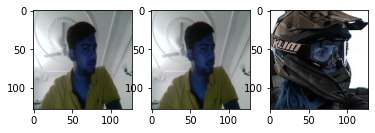

In [69]:
import matplotlib.pyplot as plt
idx = 78
plt.subplot(1,3,1)
plt.imshow(anchor_images[idx])

plt.subplot(1,3,2)
plt.imshow(same_images[idx])

plt.subplot(1,3,3)
plt.imshow(diff_images[idx])

In [70]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(img_size,img_size,3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128))
              
    model.summary()
    return model

In [74]:
img_size=128
anchor_input = tf.keras.layers.Input((img_size, img_size, 3), name='anchor_input')
positive_input = tf.keras.layers.Input((img_size, img_size, 3), name='positive_input')
negative_input = tf.keras.layers.Input((img_size, img_size, 3), name='negative_input')

shared_dnn = get_model()

encoded_anchor = shared_dnn(anchor_input)
encoded_positive = shared_dnn(positive_input)
encoded_negative = shared_dnn(negative_input)

merged_vector = tf.keras.layers.concatenate([encoded_anchor, encoded_positive, encoded_negative],
                                            axis=-1, name='merged_layer')

model = tf.keras.Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.summary()
model.compile(loss=triplet_loss, optimizer="adam")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          4160      
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)              

In [75]:
weight_dir = "weight_tripletloss_model"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')

In [76]:
Y_dummy = np.empty((anchor_images.shape[0],1))
history = model.fit([anchor_images,same_images,diff_images],y=Y_dummy, batch_size=28, epochs=30, callbacks=[checkpoint])

Epoch 1/30
16/16 [==============================] - 7s 427ms/step - loss: 6.1835
Epoch 2/30
16/16 [==============================] - 7s 418ms/step - loss: 4.4636
Epoch 3/30
16/16 [==============================] - 7s 415ms/step - loss: 0.9741
Epoch 4/30
16/16 [==============================] - 7s 418ms/step - loss: 0.3267
Epoch 5/30
16/16 [==============================] - 7s 421ms/step - loss: 0.4881
Epoch 6/30
16/16 [==============================] - 7s 418ms/step - loss: 0.1635
Epoch 7/30
16/16 [==============================] - 7s 433ms/step - loss: 0.0093
Epoch 8/30
16/16 [==============================] - 7s 426ms/step - loss: 0.0768
Epoch 9/30
16/16 [==============================] - 7s 421ms/step - loss: 0.4525
Epoch 10/30
16/16 [==============================] - 7s 419ms/step - loss: 0.1325
Epoch 11/30
16/16 [==============================] - 7s 422ms/step - loss: 0.0896
Epoch 12/30
16/16 [==============================] - 7s 423ms/step - loss: 0.3016
Epoch 13/30
16/16 [======

In [77]:
print(history.history.keys())

dict_keys(['loss'])


Text(0.5, 0, 'epoch')

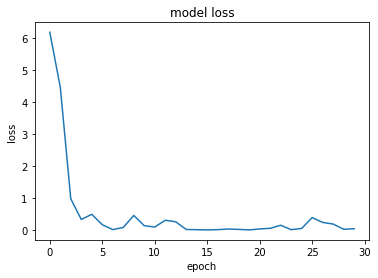

In [78]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

In [79]:
anchor_model = tf.keras.Model(inputs = anchor_input, outputs=encoded_anchor)

In [80]:
pred = anchor_model.predict(xTest)
pred.shape

(107, 128)

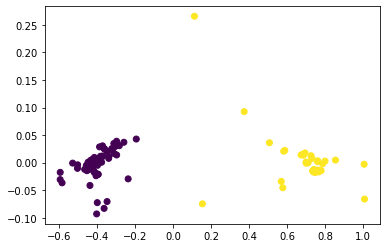

In [81]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pred_pca = pca.fit_transform(pred)

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=yTest)

In [82]:
def encode_image(model ,img):
    encode = model.predict(img.reshape((1,)+ img.shape))
    return encode

In [83]:
def dist_imgs(anchor_enc, img_enc):
    return np.linalg.norm(img_enc - anchor_enc)

In [84]:
name_dict = {}
for i in set(dataset["name"].values):
    z = dataset[dataset["name"] == i].image
    img = np.array(list(z))/255
    enc = np.zeros((1,128))
    for j in range(len(z)):
        enc += encode_image(anchor_model,img[j])

    enc = enc/len(z)
    name_dict[i] = enc

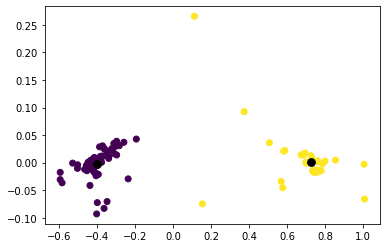

In [85]:
pca = PCA(n_components=2)
pred_pca = pca.fit_transform(pred)

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=yTest)

for val in name_dict.values():
  point = pca.transform(val)
  plt.scatter(point[0,0], point[0,1], s = [60], c='black')
plt.show()

In [86]:
def predict_image(model, img, dictionary):
    enc = encode_image(model, img)
    max_dist = 10000000
    max_name = None
    for name in dictionary:
        dist = dist_imgs(dictionary[name], enc)
        if max_dist > dist:
            max_dist = dist
            max_name = name
    
    return max_name, max_dist

Predicted name: ['helmet']  with distance 0.02495664900110318
Actual pred:  ['helmet']


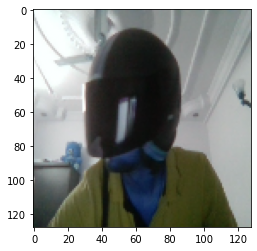

In [89]:
idx = 35
img = xTest[idx]
plt.imshow(img)

n, d = predict_image(anchor_model, img, name_dict)
print("Predicted name:",le.inverse_transform([n]) ," with distance", d)
print("Actual pred: ", le.inverse_transform(yTest[idx:idx+1]))

Predicted name: ['helmet']  with distance 0.11428507752254508
Actual pred:  ['helmet']


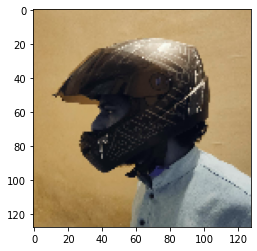

In [111]:
idx = 55
img = xTest[idx]
plt.imshow(img)

n, d = predict_image(anchor_model, img, name_dict)
print("Predicted name:",le.inverse_transform([n]) ," with distance", d)
print("Actual pred: ", le.inverse_transform(yTest[idx:idx+1]))